In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("../data/raw/uci-ml-phishing-dataset.csv")
df = df.drop(columns=["id"])

X = df.drop("Result", axis=1)
y = df["Result"].map({-1: 0, 1: 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [3]:
def add_small_noise(X, noise_level=0.05):
    X_noisy = X.copy()
    n_samples, n_features = X.shape
    n_noisy = int(noise_level * n_samples * n_features)
    
    for _ in range(n_noisy):
        i = np.random.randint(0, n_samples)
        j = np.random.randint(0, n_features)
        X_noisy.iat[i, j] = -X_noisy.iat[i, j]
    
    return X_noisy


In [4]:
top_features = [
    "SSLfinal_State",
    "URL_of_Anchor",
    "web_traffic",
    "having_Sub_Domain",
    "Links_in_tags"
]

def targeted_attack_phishing(X, y):
    X_adv = X.copy()
    
    phishing_indices = y[y == 1].index
    
    for feature in top_features:
        if feature in X_adv.columns:
            X_adv.loc[phishing_indices, feature] = -X_adv.loc[phishing_indices, feature]
    
    return X_adv


In [5]:
# Apply random noise to entire training set
X_train_noisy = add_small_noise(X_train, noise_level=0.05)

# Apply targeted phishing manipulation
X_train_targeted = targeted_attack_phishing(X_train_noisy, y_train)

# Combine original + adversarial
X_train_combined = pd.concat([X_train, X_train_targeted])
y_train_combined = pd.concat([y_train, y_train])

print("Original size:", X_train.shape)
print("Combined size:", X_train_combined.shape)


Original size: (8844, 30)
Combined size: (17688, 30)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test)


In [7]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train_combined)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_combined, y_train_combined)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [8]:
print("=== Clean Performance ===")

print("Logistic:", accuracy_score(y_test, log_model.predict(X_test_scaled)))
print("Random Forest:", accuracy_score(y_test, rf_model.predict(X_test)))
print("XGBoost:", accuracy_score(y_test, xgb_model.predict(X_test)))


=== Clean Performance ===
Logistic: 0.8900949796472184
Random Forest: 0.966078697421981
XGBoost: 0.9561284486657621


In [9]:
X_test_attacked = targeted_attack_phishing(X_test, y_test)
X_test_attacked_scaled = scaler.transform(X_test_attacked)


In [10]:
print("=== Performance Under Targeted Attack ===")

print("Logistic:", accuracy_score(y_test, log_model.predict(X_test_attacked_scaled)))
print("Random Forest:", accuracy_score(y_test, rf_model.predict(X_test_attacked)))
print("XGBoost:", accuracy_score(y_test, xgb_model.predict(X_test_attacked)))


=== Performance Under Targeted Attack ===
Logistic: 0.7770239710538218
Random Forest: 0.9348710990502035
XGBoost: 0.9258254183627318


In [11]:
# Random noise on test set
X_test_noise = add_small_noise(X_test, noise_level=0.1)
X_test_noise_scaled = scaler.transform(X_test_noise)


In [12]:
print("=== Performance Under Random Noise (10%) ===")

log_noise = accuracy_score(y_test, log_model.predict(X_test_noise_scaled))
rf_noise = accuracy_score(y_test, rf_model.predict(X_test_noise))
xgb_noise = accuracy_score(y_test, xgb_model.predict(X_test_noise))

print("Logistic:", log_noise)
print("Random Forest:", rf_noise)
print("XGBoost:", xgb_noise)


=== Performance Under Random Noise (10%) ===
Logistic: 0.7991858887381276
Random Forest: 0.8846675712347354
XGBoost: 0.8756218905472637


In [13]:
results = pd.DataFrame({
    "Model": ["Logistic", "Random Forest", "XGBoost"],
    "Clean Accuracy": [
        accuracy_score(y_test, log_model.predict(X_test_scaled)),
        accuracy_score(y_test, rf_model.predict(X_test)),
        accuracy_score(y_test, xgb_model.predict(X_test))
    ],
    "Targeted Attack": [
        accuracy_score(y_test, log_model.predict(X_test_attacked_scaled)),
        accuracy_score(y_test, rf_model.predict(X_test_attacked)),
        accuracy_score(y_test, xgb_model.predict(X_test_attacked))
    ],
    "Random Noise (10%)": [
        log_noise,
        rf_noise,
        xgb_noise
    ]
})

results


,Model,Clean Accuracy,Targeted Attack,Random Noise (10%)
0,Logistic,0.890095,0.777024,0.799186
1,Random Forest,0.966079,0.934871,0.884668
2,XGBoost,0.956128,0.925825,0.875622


In [14]:
results["Targeted Drop (%)"] = (
    (results["Clean Accuracy"] - results["Targeted Attack"])
    / results["Clean Accuracy"] * 100
)

results["Noise Drop (%)"] = (
    (results["Clean Accuracy"] - results["Random Noise (10%)"])
    / results["Clean Accuracy"] * 100
)

results


,Model,Clean Accuracy,Targeted Attack,Random Noise (10%),Targeted Drop (%),Noise Drop (%)
0,Logistic,0.890095,0.777024,0.799186,12.703252,10.213415
1,Random Forest,0.966079,0.934871,0.884668,3.230337,8.426966
2,XGBoost,0.956128,0.925825,0.875622,3.169347,8.420057


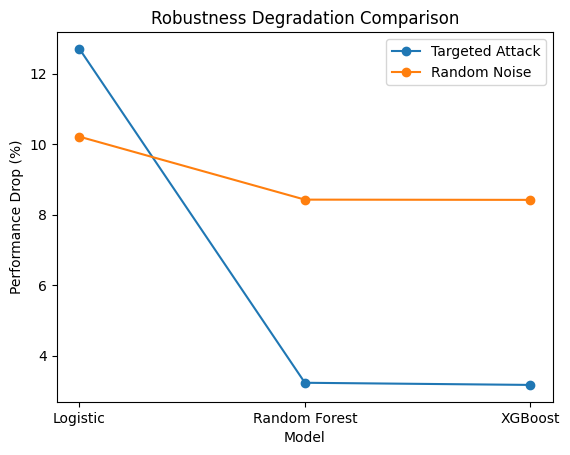

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(results["Model"], results["Targeted Drop (%)"], marker='o')
plt.plot(results["Model"], results["Noise Drop (%)"], marker='o')

plt.title("Robustness Degradation Comparison")
plt.xlabel("Model")
plt.ylabel("Performance Drop (%)")
plt.legend(["Targeted Attack", "Random Noise"])
plt.show()
plt.savefig("../results/figures/plot_name.png", dpi=300, bbox_inches="tight")


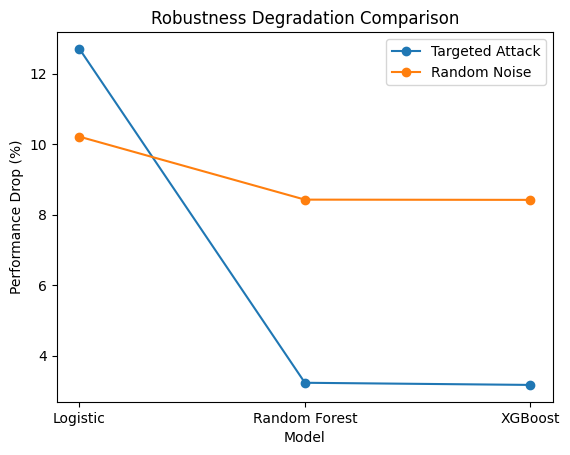

In [18]:
plt.figure()

plt.plot(results["Model"], results["Targeted Drop (%)"], marker='o')
plt.plot(results["Model"], results["Noise Drop (%)"], marker='o')

plt.title("Robustness Degradation Comparison")
plt.xlabel("Model")
plt.ylabel("Performance Drop (%)")
plt.legend(["Targeted Attack", "Random Noise"])

# SAVE BEFORE SHOW
plt.savefig("../results/figures/robustness_comparison.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()
